#Mesonet Research Project - Minnesota

This notebook shows how I combined numerous data sources into one dataset to determine suitability for placing a climate sensor. In contrast to example 1 and vector shapes, the mesonet project worked entirely with raster datasets.

In [45]:
#Import packages
import rasterio
import rasterio.features
import rasterio.warp
import requests
from zipfile import ZipFile
import fiona
import geopandas as gpd
import numpy as np

In [46]:
# Source urls
elevationURL = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/elev_30m_digital_elevation_model/fgdb_elev_30m_digital_elevation_model.zip'
landcoverURL = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_landcover_nlcd_mn_2016/tif_biota_landcover_nlcd_mn_2016.zip'

In [47]:
elevation = rasterio.open('digital_elevation_model_3.tif')

In [48]:
from rasterio.plot import show
#show(elevation)

In [49]:
#landcover = rasterio.open('NLCD_2011_MN_Landcover.tif')
#show(landcover)

In [50]:
#!pip install shapely
#!pip install pycrs

## Slope

In [51]:
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
import pycrs

In [52]:
#!pip install ospybook-latest.zip

In [53]:
# Script to compute slope from a DEM.
# From "Geoprocessing with Python" by Chris Garrard (p. 253)

import os
import numpy as np
from osgeo import gdal
import ospybook as pb

in_fn = 'Elevation_30m_Study_Area.tif'
out_fn = 'Study_Area_Slopes.tif'

# Get cell width and height.
in_ds = gdal.Open(in_fn)
cell_width = in_ds.GetGeoTransform()[1]
cell_height = in_ds.GetGeoTransform()[5]

# Read the data into a floating point array.
band = in_ds.GetRasterBand(1)
in_data = band.ReadAsArray().astype(float)

# Initialize the output array with -99.
out_data = np.ones((band.YSize, band.XSize)) * -99

# Make the slices.
slices = pb.make_slices(in_data, (3, 3))

# Compute the slope using the equations from the text.
rise = ((slices[6] + (2 * slices[7]) + slices[8]) -
        (slices[0] + (2 * slices[1]) + slices[2])) / \
       (8 * cell_height)
run =  ((slices[2] + (2 * slices[5]) + slices[8]) -
        (slices[0] + (2 * slices[3]) + slices[6])) / \
       (8 * cell_width)
dist = np.sqrt(np.square(rise) + np.square(run))

# The output from the last equation is inserted into the middle
# of the output array, ignoring the edges again.
out_data[1:-1, 1:-1] = np.arctan(dist) * 180 / np.pi

# Save the data.
pb.make_raster(in_ds, out_fn, out_data, gdal.GDT_Float32, -99)
del in_ds

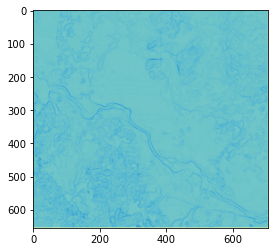

In [54]:
import matplotlib.pyplot as plt

plt.imshow(out_data, cmap="GnBu")

In [55]:
out_data.shape

(655, 707)

In [56]:
Study_Area_Slope = out_data
Study_Area_Slope.shape

(655, 707)

#### Reclassify appropriate and inappropriate slopes

In [57]:
ds_slopes = gdal.Open('Study_Area_Slopes.tif')
ds_slopes

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fadfad6f5d0> >

In [58]:
band_slopes = ds_slopes.GetRasterBand(1)
band_slopes

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fadfad75840> >

In [59]:
array_slopes = band_slopes.ReadAsArray()
array_slopes

array([[-99.       , -99.       , -99.       , ..., -99.       ,
        -99.       , -99.       ],
       [-99.       ,  86.75908  ,  86.55951  , ...,  86.50003  ,
         86.699745 , -99.       ],
       [-99.       ,  86.56037  ,   3.520405 , ...,   0.       ,
         86.50003  , -99.       ],
       ...,
       [-99.       ,  86.75497  ,  14.155488 , ...,   3.3890672,
         86.38137  , -99.       ],
       [-99.       ,  86.759544 ,  11.653262 , ...,   4.822542 ,
         86.373764 , -99.       ],
       [-99.       , -99.       , -99.       , ..., -99.       ,
        -99.       , -99.       ]], dtype=float32)

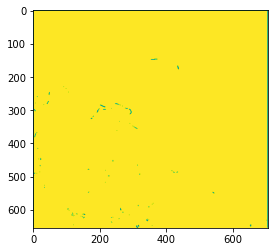

In [60]:
Study_Area_OK_Slopes = np.where(array_slopes <= 33.333,1,0)
Study_Area_OK_Slopes
plt.figure()
plt.imshow(Study_Area_OK_Slopes)

In [323]:
Study_Area_OK_Slopes_tif = Study_Area_OK_Slopes+1

In [324]:
# Convert array to .tif
ds = gdal.Open("Study_Area_Slopes.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("slopes.tif",xsize = Study_Area_OK_Slopes_tif.shape[1],ysize = Study_Area_OK_Slopes_tif.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(Study_Area_OK_Slopes_tif)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

## Landcover

#### Water

In [62]:
# Extract all cells that are water

#### Reclassify to be the same value

In [63]:
ds_water = gdal.Open('NLCD_Study_Area.tif')
gt_water =ds_water.GetGeoTransform()
proj_water = ds_water.GetProjection()
band_water = ds_water.GetRasterBand(1)
array_water = band_water.ReadAsArray()
array_water

array([[ 0, 82, 82, ..., 82, 82,  0],
       [ 0, 82, 82, ..., 82, 82,  0],
       [ 0, 82, 82, ..., 82, 82,  0],
       ...,
       [ 0, 41, 82, ..., 81, 81,  0],
       [ 0, 41, 82, ..., 81, 81,  0],
       [ 0, 41, 82, ..., 22, 21,  0]], dtype=uint8)

In [64]:
water_11 = np.where(array_water == 11,0,1)
water_90 = np.where(array_water == 90,0,1)
water_95 = np.where(array_water == 95,0,1)

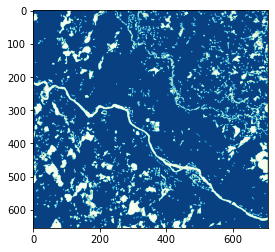

In [65]:
water = water_11 + water_90 + water_95
plt.figure()
plt.imshow(water, cmap="GnBu")

In [66]:
# Buffer water by 3 cells (90m)

In [227]:
#Convert water from 3's to 1's to make the buffer work (1 being water present)
water_1 = water/3
water_1

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [233]:
# Buffer by 3 cells

from scipy.ndimage import minimum_filter
buffer_size = 3
water_buffered = minimum_filter(water_1, size=2*buffer_size+1, mode='constant', cval=1)

In [325]:
water_buffered_tif = water_buffered+1
water_buffered_tif

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [329]:
# Convert array to .tif
ds = gdal.Open("Study_Area_Slopes.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("water_buffered_tif.tif",xsize = water_buffered_tif.shape[1],ysize = water_buffered_tif.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(water_buffered_tif)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

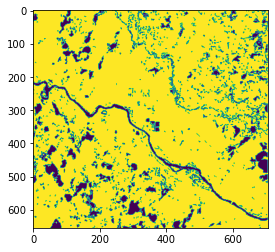

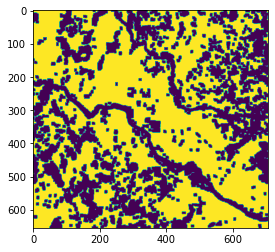

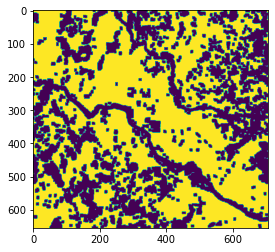

<AxesSubplot:>

In [331]:
show(water)
show(water_buffered)
show(water_buffered_tif)

#### Forest

In [ ]:
# Extract all cells that are forest

#### Reclassify to be the same value

In [241]:
ds_forest = gdal.Open('NLCD_Study_Area.tif')
ds_forest

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fae250d73f0> >

In [242]:
gt_forest =ds_forest.GetGeoTransform()
gt_forest

(420020.0, 30.0, 0.0, 5034880.0, 0.0, -30.0)

In [243]:
proj_forest = ds_forest.GetProjection()
proj_forest

'PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26915"]]'

In [244]:
band_forest = ds_forest.GetRasterBand(1)
band_forest

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fae250ecb40> >

In [245]:
array_forest = band_forest.ReadAsArray()
array_forest

array([[ 0, 82, 82, ..., 82, 82,  0],
       [ 0, 82, 82, ..., 82, 82,  0],
       [ 0, 82, 82, ..., 82, 82,  0],
       ...,
       [ 0, 41, 82, ..., 81, 81,  0],
       [ 0, 41, 82, ..., 81, 81,  0],
       [ 0, 41, 82, ..., 22, 21,  0]], dtype=uint8)

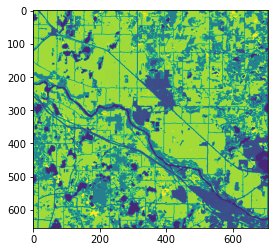

In [246]:
plt.figure()
plt.imshow(array_forest)

In [274]:
forest_41 = np.where(array_forest == 41,0,1)
forest_41

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1]])

In [275]:
forest_42 = np.where(array_forest == 42,0,1)
forest_42

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [276]:
forest_43 = np.where(array_forest == 43,0,1)
forest_43

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [289]:
forest = forest_41 + forest_42 + forest_43

#### Buffer forested areas by 5 cells (150m)

In [299]:
# Buffer by 5 cells

from scipy.ndimage import minimum_filter
buffer_size = 5
forest_buffered = minimum_filter(forest, size=2*buffer_size+1, mode='constant', cval=1)

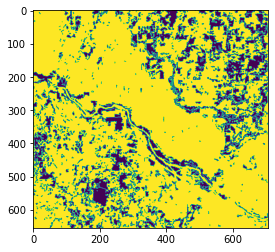

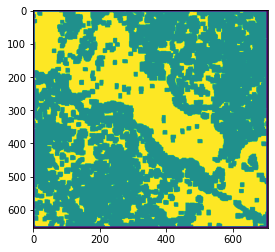

<AxesSubplot:>

In [300]:
show(forest)
show(forest_buffered)

### Vegetation

In [ ]:
# Extract all vegetated and agricultural landcover

In [ ]:
# Reclassify to be the same value

In [305]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [306]:
ds_veg = gdal.Open('NLCD_Study_Area.tif')
ds_veg

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fae255a0570> >

In [307]:
gt_veg=ds_veg.GetGeoTransform()
gt_veg

(420020.0, 30.0, 0.0, 5034880.0, 0.0, -30.0)

In [308]:
proj_veg = ds_veg.GetProjection()
proj_veg

'PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26915"]]'

In [309]:
band_veg = ds_veg.GetRasterBand(1)
band_veg

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fadfaae1f00> >

In [310]:
array_veg = band_veg.ReadAsArray()
array_veg

array([[ 0, 82, 82, ..., 82, 82,  0],
       [ 0, 82, 82, ..., 82, 82,  0],
       [ 0, 82, 82, ..., 82, 82,  0],
       ...,
       [ 0, 41, 82, ..., 81, 81,  0],
       [ 0, 41, 82, ..., 81, 81,  0],
       [ 0, 41, 82, ..., 22, 21,  0]], dtype=uint8)

In [311]:
veg_71 = np.where(array_veg == 71,1,0)
veg_71

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [312]:
veg_81 = np.where(array_veg == 81,1,0)
veg_81

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [313]:
veg_82 = np.where(array_veg == 82,1,0)
veg_82

array([[0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [314]:
vegetation = veg_71 + veg_81 + veg_82

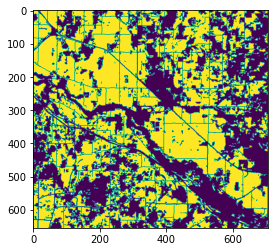

In [315]:
plt.figure()
plt.imshow(vegetation)

## Summation

In [317]:
#Add all the final maps up
summation = vegetation + forest_buffered + water_buffered + Study_Area_OK_Slopes
summation

array([[3., 4., 4., ..., 4., 4., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 4., ..., 4., 3., 3.],
       ...,
       [3., 2., 4., ..., 4., 3., 3.],
       [3., 2., 4., ..., 4., 3., 3.],
       [3., 3., 4., ..., 3., 3., 3.]])

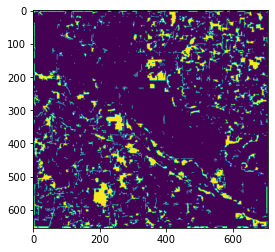

In [319]:
final_suitability_study_area = np.where(summation == 4,1,0)
final_suitability_study_area
plt.figure()
plt.imshow(final_suitability_study_area)

In [332]:
final_suitability_study_area_tif = final_suitability_study_area + 2

In [333]:
# Convert array to .tif
ds = gdal.Open("NLCD_Study_Area.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("study_area_suitability.tif",xsize = final_suitability_study_area_tif.shape[1],ysize = final_suitability_study_area_tif.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(final_suitability_study_area_tif)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None